### Importing necessary libraries

In [157]:
import pandas as pd
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder # Label encoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer()
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import model_selection
# from scipy.stats import zscore

from sklearn.model_selection import KFold
from imblearn.pipeline import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel


labelencoder = LabelEncoder()

### Merging dataset files

In [158]:
fund_config = pd.read_csv('fund_config.csv')
fund_ratios = pd.read_csv('fund_ratios.csv', thousands=',')
bond_ratings = pd.read_csv('bond_ratings.csv', thousands=',')
fund_allocations = pd.read_csv('fund_allocations.csv', thousands=',') # ID
fund_specs = pd.read_csv('fund_specs.csv', thousands=',')
other_specs = pd.read_csv('other_specs.csv', thousands=',')
return_3year = pd.read_csv('return_3year.csv', thousands=',')
return_5year = pd.read_csv('return_5year.csv', thousands=',')
return_10year = pd.read_csv('return_10year.csv', thousands=',')
fund_allocations.rename(columns={'id': 'tag'}, inplace=True)

data = fund_config.merge(fund_ratios, on='fund_id',suffixes=('_left', '_right') )
data = data.merge(bond_ratings, on='tag',suffixes=('_left', '_right'))
data = data.merge(fund_allocations, on='tag',suffixes=('_left', '_right'))
data = data.merge(fund_specs, on='tag',suffixes=('_left', '_right'))
data = data.merge(other_specs, on='tag',suffixes=('_left', '_right'))
data = data.merge(return_3year, on='tag',suffixes=('_left', '_right'))
data = data.merge(return_5year, on='tag',suffixes=('_left', '_right'))
data = data.merge(return_10year, on='fund_id',suffixes=('_left', '_right'))

data['greatstone_rating'] = data.apply(
    lambda row: row['greatstone_rating_left'],
    axis=1
)

data.drop(['greatstone_rating_left', 'greatstone_rating_right', 'tag'], axis=1, inplace=True)

test_data = pd.DataFrame(data[data['greatstone_rating'].isnull()])

data.drop(data[data['greatstone_rating'].isnull()].index.tolist(), inplace=True, axis=0)

# data.greatstone_rating.replace({0: 1}, inplace=True)

# data = data.reset_index(drop=True)

# # dropping rows which has more than 50 null value
# null_values_indexs = []
# for i in range(len(data.index)) :
#     if data.iloc[i].isnull().sum() > 30 :
#         # print("Nan in row ", i , " : " ,  data.iloc[i].isnull().sum())
#         null_values_indexs.append(i)
        
# print(f'\nDroping rows: {len(null_values_indexs)}')
# print(f'\nDroping rows: {null_values_indexs}')
# data.drop(null_values_indexs, inplace=True)

In [159]:
data.head(5)

,category,parent_company,fund_id,fund_name,fund_ratio_net_annual_expense,pb_ratio_left,ps_ratio_left,mmc_left,pc_ratio_left,pe_ratio_left,...,10yrs_treynor_ratio_fund,10_years_return_mean_annual_category,10yrs_treynor_ratio_category,10_years_return_fund,10_years_alpha_category,10_years_beta_category,10years_category_std,10_years_return_mean_annual_fund,10_years_return_category,greatstone_rating
1,Large Growth,Janus Henderson,f5ad58c2-fdea-4087-8678-e04744f89f90,Janus Henderson Research Fund Class N,0.58,5.30,3.38,72347.03,15.95,18.88,...,15.57,0.01,0.15,17.25,-0.01,0.01,0.14,1.42,15.94,3.0
2,Large Growth,Calvert Research and Management,3c13f4ab-02c4-4ca7-a133-7e996ec5d0c4,Calvert Equity Fund Class A,0.99,5.40,3.67,68857.43,15.97,23.27,...,16.58,0.01,0.15,16.21,-0.01,0.01,0.14,1.33,15.94,4.0
3,Large Value,Invesco,ff78bdd8-59eb-4cef-9f3c-b1baacce9554,Invesco Diversified Dividend Fund R5 Class,0.52,2.23,1.63,43266.62,8.93,12.70,...,16.38,0.01,0.14,14.12,-0.02,0.01,0.13,1.16,13.68,3.0
4,Target-Date 2035,PGIM Funds (Prudential),63d8406d-c525-494a-8e03-d4fc4cfcb571,Prudential Day One 2035 Fund Class R3,0.75,2.02,1.40,43747.90,7.59,14.74,...,NaN,0.01,0.08,0.00,-0.02,0.01,0.12,NaN,11.53,0.0
5,Convertibles,Teton Westwood Funds,090afb4d-eca3-4f69-8275-a140a0b40292,TETON Convertible Securities Fund Class C,1.90,0.00,0.00,0.00,0.00,0.00,...,8.44,0.01,0.09,10.77,0.00,0.01,0.10,0.91,11.07,3.0


### EDA

#### Dataset Info

In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 24997
Columns: 129 entries, category to greatstone_rating
dtypes: float64(121), object(8)
memory usage: 19.8+ MB


In [161]:
categorical_features = data.select_dtypes(include=['object']).columns
print(f'\nCategorical Features: {categorical_features}\n')


Categorical Features: Index(['category', 'parent_company', 'fund_id', 'fund_name',
       'investment_class', 'currency', 'inception_date', 'fund_size'],
      dtype='object')



In [162]:
cols_to_drop = ['category', 'parent_company', 'fund_id', 'fund_name', 'currency', 'inception_date']

In [163]:
numeric_features = data.select_dtypes(include=['int64', 'float64']).columns
print(f'\n Numeric Features: {numeric_features}\n')


 Numeric Features: Index(['fund_ratio_net_annual_expense', 'pb_ratio_left', 'ps_ratio_left',
       'mmc_left', 'pc_ratio_left', 'pe_ratio_left', 'bb_rating',
       'us_govt_bond_rating', 'below_b_rating', 'others_rating',
       ...
       '10yrs_treynor_ratio_fund', '10_years_return_mean_annual_category',
       '10yrs_treynor_ratio_category', '10_years_return_fund',
       '10_years_alpha_category', '10_years_beta_category',
       '10years_category_std', '10_years_return_mean_annual_fund',
       '10_years_return_category', 'greatstone_rating'],
      dtype='object', length=121)



#### Dataset describe

In [164]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fund_ratio_net_annual_expense,20000.0,1.121047,0.608311,0.00,0.71,1.01,1.44,10.64
pb_ratio_left,19905.0,1.844200,2.882882,0.00,0.56,1.85,2.38,123.30
ps_ratio_left,19905.0,1.830336,34.195284,0.00,0.32,1.29,1.80,2777.78
mmc_left,19905.0,28189.264936,33639.867317,0.00,445.75,16818.33,42958.60,363960.31
pc_ratio_left,19905.0,19.877164,511.412487,0.00,0.51,6.98,8.94,20000.00
...,...,...,...,...,...,...,...,...
10_years_beta_category,19918.0,0.009066,0.005417,-0.02,0.01,0.01,0.01,0.12
10years_category_std,19918.0,0.109273,0.055199,0.00,0.06,0.12,0.15,0.34
10_years_return_mean_annual_fund,13117.0,0.856611,0.462152,-3.64,0.52,0.89,1.20,3.28
10_years_return_category,19907.0,9.657428,4.951263,-24.99,6.44,9.97,14.12,18.72


#### Checking missing values

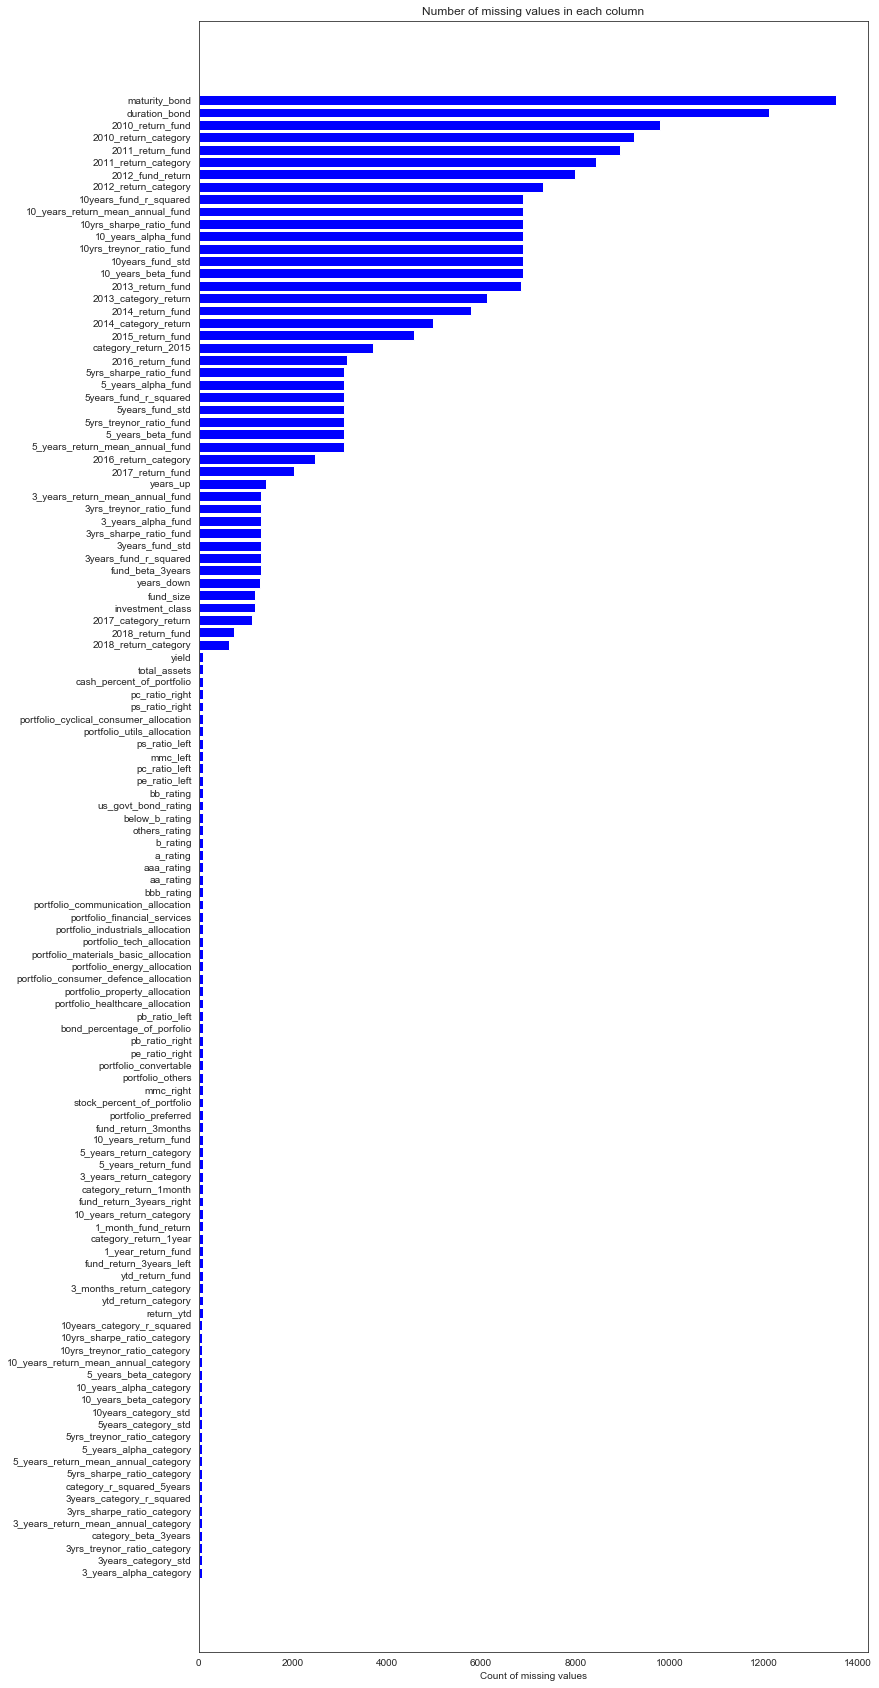

In [165]:
missing_df = data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,30))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

#### Finding correlation

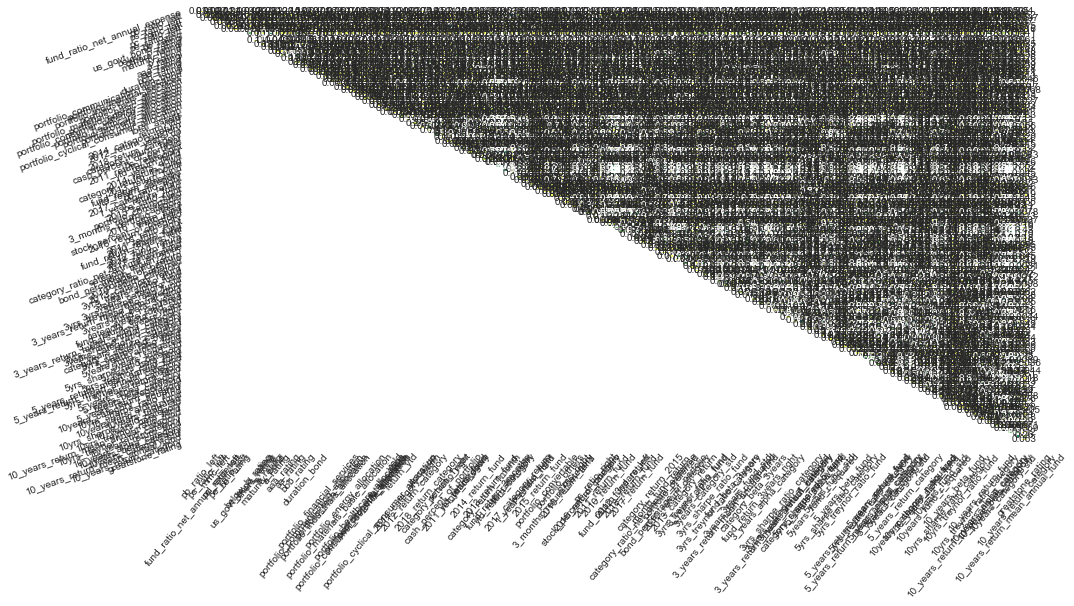

We can drop ['pc_ratio_right', 'ytd_return_fund', 'fund_return_3months', 'pb_ratio_right', 'pe_ratio_right', '3_months_return_category', 'mmc_right', 'ps_ratio_right', '3_years_return_mean_annual_fund', 'fund_return_3years_right', 'category_r_squared_5years', '5years_fund_r_squared', '5years_fund_std', '5_years_beta_fund', '5_years_return_fund', '5years_category_std', '10years_fund_std', '10years_category_std', '10_years_return_mean_annual_fund'] 

We will drop ['pc_ratio_right', 'ytd_return_fund', 'fund_return_3months', 'pb_ratio_right', 'pe_ratio_right', '3_months_return_category', 'mmc_right', 'ps_ratio_right', 'category_r_squared_5years', '5years_fund_std', '5_years_beta_fund', '10years_fund_std', '10years_category_std'] 



In [166]:
# Create correlation matrix
corr_matrix = data[numeric_features].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

mask = upper == 0  # to mask the upper triangle in the following heatmap

plt.figure(figsize = (15,8))  # setting the figure size
sns.set_style(style = 'white')  # Setting it to white so that we do not see the grid lines
g = sns.heatmap(upper, center=0.5, cmap= 'summer_r', annot= True, xticklabels = corr_matrix.index, 
                yticklabels = corr_matrix.columns, cbar= False, linewidths= 1, mask = mask)   # Da Heatmap
g.set_yticklabels(g.get_yticklabels(), rotation=0, horizontalalignment='right')
bottom, top = g.get_ylim()
g.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(rotation = 50)   # Aesthetic purposes
plt.yticks(rotation = 20)   # Aesthetic purposes
plt.show()

# Find index of feature columns with correlation greater than 0.95
corr_to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]


remove_list = ['pc_ratio_right', 'ytd_return_fund', 'fund_return_3months', 'pb_ratio_right', 'pe_ratio_right', '3_months_return_category', 'mmc_right', 'ps_ratio_right', 'category_r_squared_5years', '5years_fund_std', '5_years_beta_fund', '10years_fund_std', '10years_category_std']

print(f'We can drop {corr_to_drop} \n')

print(f'We will drop {remove_list} \n')

In [167]:
cols_to_drop += remove_list
print(f'Columns to drop: {cols_to_drop}')

Columns to drop: ['category', 'parent_company', 'fund_id', 'fund_name', 'currency', 'inception_date', 'pc_ratio_right', 'ytd_return_fund', 'fund_return_3months', 'pb_ratio_right', 'pe_ratio_right', '3_months_return_category', 'mmc_right', 'ps_ratio_right', 'category_r_squared_5years', '5years_fund_std', '5_years_beta_fund', '10years_fund_std', '10years_category_std']


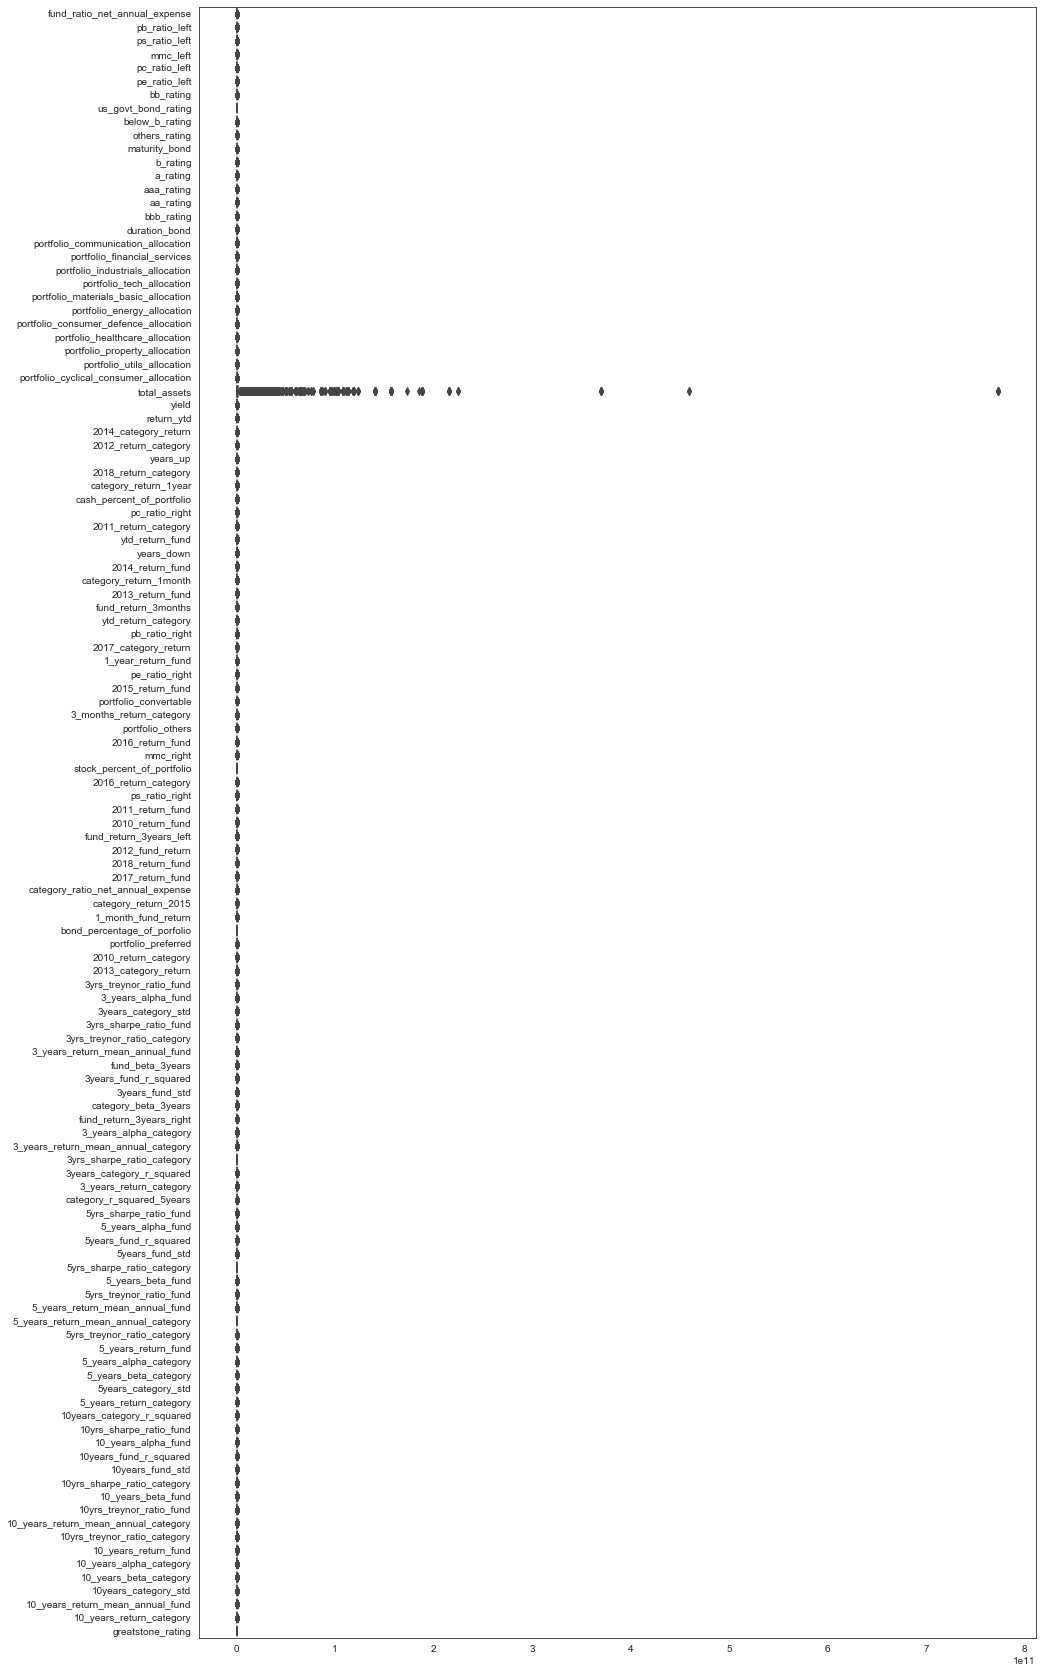

In [168]:
plt.figure(figsize=(15,30))
sns.boxplot(data=data, orient='h')

#### Checking target distribution

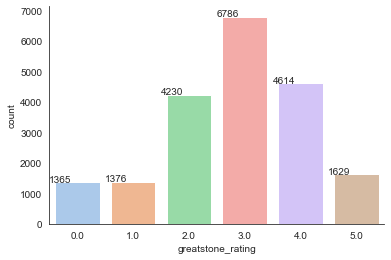

In [169]:
ax = sns.countplot(x="greatstone_rating", data=data, palette="pastel")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for p in ax.patches:
    ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+5), ha='center')

plt.show()

### Separting dependent and Independent variables and resampling

In [170]:
X = data.drop('greatstone_rating', axis=1)
y = data.greatstone_rating

y = label_binarizer.fit_transform(y)

### Spliting dataset into train and validation data

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [172]:
# train = pd.concat([X_train, y_train], axis = 1)

# extra_samples = train[train['greatstone_rating'] == 1].sample(n = 2000, random_state = 1)
# train_upsampled = pd.concat([train, extra_samples], axis = 0)

# extra_samples = train[train['greatstone_rating'] == 5].sample(n = 2000, random_state = 1)
# train_upsampled = pd.concat([train_upsampled, extra_samples], axis = 0)


# X_train = train_upsampled.drop(columns = 'greatstone_rating', axis=1)
# y_train = label_binarizer.fit_transform(train_upsampled.greatstone_rating)

### Outliers handling on the train dataset

In [173]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [174]:
# outliers handling

for i in numeric_features:
    q1, q2, q3 = X_train[i].quantile([0.25,0.5,0.75])
    IQR = q3 - q1
    a = X_train[i] > q3 + 1.5*IQR
    b = X_train[i] < q1 - 1.5*IQR
    X_train[i] = np.where(a | b, q2, X_train[i])
    

C:\Users\amol.matkar\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Creating pipeline

In [175]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('drop_columns', 'drop', cols_to_drop),
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# rfc= RandomForestClassifier(n_estimators = 200, random_state=1, max_depth=30, criterion='entropy')

# {'n_estimators': 250,
#  'min_samples_split': 2,
#  'min_samples_leaf': 3,
#  'max_features': 'auto',
#  'max_depth': 30,
#  'bootstrap': False}

rfc = RandomForestClassifier(
    n_estimators=250,
    random_state=1,
    max_depth=30, 
    criterion='entropy'
)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(rfc, threshold=0.003)),
    ('classifier', rfc)
])

# clf = Pipeline(steps=[('preprocessor', preprocessor),
#                       ('classifier', rfc)])

### Cross validation

In [176]:
# kfold = KFold(n_splits=10, random_state=1, shuffle=True)

# rfcl_cross_val_score = model_selection.cross_val_score(
#     clf, X_train, y_train, cv=kfold, scoring='average_precision')

# print(rfcl_cross_val_score)

# print(rfcl_cross_val_score.mean())

# print(rfcl_cross_val_score.std())

### Fitting train data into pipline

In [177]:
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('drop_columns', 'drop',
                                                  ['category', 'parent_company',
                                                   'fund_id', 'fund_name',
                                                   'currency', 'inception_date',
                                                   'pc_ratio_right',
                                                   'ytd_return_fund',
                                                   'fund_return_3months',
                                                   'pb_ratio_right',
                                                   'pe_ratio_right',
                                                   '3_mon...
                 RandomForestClassifie

In [178]:
print("Train data model score: %.3f" % clf.score(X_train, y_train))
print("Test data model score: %.3f" % clf.score(X_test, y_test))

Train data model score: 1.000
Test data model score: 0.667


#### Calcuating precision score.

In [179]:
y_pred = clf.predict(X_test)
print("model score: %.3f" % metrics.precision_score(y_test, y_pred, average='micro'))

model score: 0.863


### Predicting on test data and creating submission file

In [180]:
test_data_copy = test_data.copy()
fund_ids = test_data.fund_id
# test_data.drop(cols_to_drop, axis=1, inplace=True)
test_data.drop(['greatstone_rating'], axis=1, inplace=True)

In [181]:
# test_data.drop(cols_to_drop, axis=1, inplace=True)
test_data.shape

(5000, 128)

In [182]:
y_test_data_pred = clf.predict(test_data)


In [183]:
label_binarizer.inverse_transform(y_test_data_pred)

array([0., 4., 2., ..., 3., 2., 2.])

In [184]:
predicted = label_binarizer.inverse_transform(y_test_data_pred)

In [185]:
predicted

array([0., 4., 2., ..., 3., 2., 2.])

In [186]:
submission = pd.DataFrame({'fund_id': fund_ids, 'greatstone_rating': predicted})

submission

,fund_id,greatstone_rating
0,264614c6-5ac3-4146-ba26-1674b136cb40,0.0
7,08702e4f-c5bb-4f0a-b63b-f9e4a0eb2425,4.0
16,cf56db43-046b-49d0-b8f0-90fe9cf8aacf,2.0
24,3faa81fc-9640-43d0-8b68-e5b06c65bfe6,0.0
28,09e24f3d-7191-4207-887c-98f31c6b59d2,3.0
...,...,...
24983,fc278788-24bf-4844-a538-d8c67d47275c,3.0
24992,0a3c101f-c969-4e85-8395-3dc3e33dd3d6,4.0
24996,12fc8949-6563-4dd4-a7cc-0400131fa6ab,3.0
24998,65421547-1407-4c50-92dc-e1cb1e9972dd,2.0


In [187]:
sub = pd.read_csv('sample_submission.csv')

In [188]:
newdf = pd.DataFrame()
for i in range(len(sub)) :
    fund_id = sub.loc[i, "fund_id"]
    greatstone_rating = submission.loc[submission[submission['fund_id'] == fund_id].index.to_list()[0], "greatstone_rating"]
    newdf = newdf.append({'fund_id': fund_id, 'greatstone_rating': greatstone_rating}, ignore_index=True)    

In [189]:
newdf[newdf['fund_id']=='fc278788-24bf-4844-a538-d8c67d47275c']

,fund_id,greatstone_rating
3168,fc278788-24bf-4844-a538-d8c67d47275c,3.0


In [190]:
newdf.to_csv('submission_file.csv', index=False)

<hr/><hr/><hr/>

In [191]:
# X_train

In [192]:
# X_train.investment_class.fillna("Unknown", inplace=True)
# X_train.investment_class = labelencoder.fit_transform(X_train.investment_class)

# X_train.fund_size.fillna("Unknown", inplace=True)
# X_train.fund_size = labelencoder.fit_transform(X_train.fund_size)

# X_train.drop(cols_to_drop, axis=1, inplace=True)

# for col in X_train.columns:
#     X_train[col].fillna(X_train[col].median(), inplace=True)

# from sklearn.model_selection import RandomizedSearchCV

# # Number of trees in random forest
# n_estimators = [100, 150, 200, 250, 300]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt', 'log2']
# # Maximum number of levels in tree
# max_depth = [10,20,30,40]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10, 15, 20, 25, 30]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 3, 5, 10, 15, 20, 25, 30]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# print(random_grid)

# # Instantiate the grid search model
# rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring='average_precision')

# # Fit the random search model
# rf_random.fit(X_train, y_train)

# rf_random.best_params_

# rf_random.best_estimator_

# rf_random.best_score_